In [1]:
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers import Input, LSTM, Dense, Embedding
from keras.models import Sequential, Model
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras.utils import plot_model
import keras.backend as K

from sklearn.model_selection import train_test_split
from IPython.display import Image
from sklearn.decomposition import PCA
import tensorflow as tf 

import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
import pickle

Using TensorFlow backend.


In [2]:
data = pd.read_csv('grade_item.csv', sep=",") #93개의 주요 상품들 존재
data.head()

CUSTOMER  FASH-WO  FASH-MA  FASH-WAT  FASH-JUR  FASH-UND  FASH-MBAG  \
0    CUS-1        9        6         7         2         5          3   
1    CUS-2        8        0         6         6         1          9   
2    CUS-3        9        5         8         3         9          6   
3    CUS-4        3        8         3         0         2          8   
4    CUS-5        0        9         1         8         5          1   

   FASH-WBAG  FASH-MIS  FASH-WWAL  ...  DIGI-CELL  DIGI-NOTE  DIGI-SOUND  \
0          8         5          7  ...          5          2          10   
1          6         1          2  ...          6          1           3   
2          0        10          4  ...          4          6           9   
3          6         9          7  ...          2          1           3   
4          6         6          2  ...          2          1           5   

   DIGI-GAME  DIGI-LIFE  DIGI-PRT  DIGI-PC  DIGI-DISP  DIGI-HARD  PERFORM  
0          4          6         4        3         10          6        0  
1          4          3         4        0          3          7        4  
2         10          1         1        6          1          2        4  
3          7          6         0        8          1          4        6  
4          5          0         6        2          7          7        4  

[5 rows x 94 columns]

In [3]:
data = data.drop("CUSTOMER",1) #고객아이디는 분석 대상 아님
data.head()

FASH-WO  FASH-MA  FASH-WAT  FASH-JUR  FASH-UND  FASH-MBAG  FASH-WBAG  \
0        9        6         7         2         5          3          8   
1        8        0         6         6         1          9          6   
2        9        5         8         3         9          6          0   
3        3        8         3         0         2          8          6   
4        0        9         1         8         5          1          6   

   FASH-MIS  FASH-WWAL  FASH-MWAL  ...  DIGI-CELL  DIGI-NOTE  DIGI-SOUND  \
0         5          7          5  ...          5          2          10   
1         1          2          9  ...          6          1           3   
2        10          4          5  ...          4          6           9   
3         9          7          1  ...          2          1           3   
4         6          2          1  ...          2          1           5   

   DIGI-GAME  DIGI-LIFE  DIGI-PRT  DIGI-PC  DIGI-DISP  DIGI-HARD  PERFORM  
0          4          6         4        3         10          6        0  
1          4          3         4        0          3          7        4  
2         10          1         1        6          1          2        4  
3          7          6         0        8          1          4        6  
4          5          0         6        2          7          7        4  

[5 rows x 93 columns]

In [4]:
data.shape

(70000, 93)

In [5]:
factor_sum = 0

for i in range(data.shape[1]):
    #print(len(data.iloc[:,i].value_counts()))
    factor_sum +=len(data.iloc[:,i].value_counts()) #사전의 크기를 구하는 것
# 0~10 평점 11 * 제품의 수 93
print(factor_sum) #사전의 크기 1023

1023


In [6]:
colnames=data.columns
from random import shuffle

REP=1 # number of shuffled sentences
sentences = [] #셔플링 사용, 모델이 고객 순서를 학습하지 않도록 하기 
for i in range(data.shape[0]):
    if i%10000==0:
        print(i) # 0부터 10000에 나누어지는 것 출력
    for j in range(REP):
        sentence=list(colnames + data.iloc[i,:].map(str))
        np.random.shuffle(sentence)
        sentences.append(sentence)

0
10000
20000
30000
40000
50000
60000


In [7]:
sentences

[['FASH-MIS5',
  'FOOD-COFF7',
  'DIGI-PC3',
  'CLOTH-TRAL2',
  'DIGI-HARD6',
  'CLOTH-MWAL2',
  'LIFE-BATH8',
  'DIGI-LIFE6',
  'FURN-OUT5',
  'OFFICE9',
  'CAT6',
  'CLOTH-WO5',
  'LESR-OTH4',
  'LESR-FISH5',
  'LIFE-KIT5',
  'CLOTH-WWAL5',
  'FURN-CHR8',
  'DIGI-DISP10',
  'CLOTH-MSHO1',
  'DIGI-AIR8',
  'FURN-DESK3',
  'BEAT-MAST6',
  'DIGI-WASH2',
  'LIFE-MOU2',
  'TRV-AIR10',
  'BEAT-LOTT2',
  'CLOTH-WBAG6',
  'FURN-BED9',
  'LIFE-MASS8',
  'FOOD-DIET5',
  'LESR-SKI8',
  'LESR-SPT5',
  'BEAT-MAKE3',
  'LESR-SWIM9',
  'FASH-WWAL7',
  'FURN-CHID4',
  'FURN-INN7',
  'DIGI-PRT4',
  'FURN-LIGT0',
  'BEAT-SKIN10',
  'FASH-UND5',
  'DOG1',
  'LESR-HEAT2',
  'ART2',
  'BEAT-BODY5',
  'CLOTH-MA3',
  'BOOK1',
  'PERFORM0',
  'FOOD-ANI0',
  'CLOTH-CHID6',
  'FURN-REM10',
  'FOOD-PROC7',
  'BEAT-ESSN2',
  'FASH-WO9',
  'FISH9',
  'FOOD-MAR5',
  'DIGI-TV7',
  'FASH-JUR2',
  'CLOTH-WSHO3',
  'DIGI-NOTE2',
  'FASH-MA6',
  'DIGI-GAME4',
  'FOOD-WELL8',
  'FASH-WAT7',
  'BEAT-HAIR8',
  'FOOD-AGR6

In [8]:
from gensim.models import Word2Vec #Word2Vec를 통한 모델링
embed_model = Word2Vec(sentences, sg=1, size=50, window=5, min_count=1) #window의 크기는 5
embed_model.save("word2vec_ITEM_GRADE") #하나의 단어는 50의 크기를 가진 벡터가 됨
(embed_model.wv.vocab) #즉 embeding 차원 크기 50

{'FASH-MIS5': <gensim.models.keyedvectors.Vocab at 0x21179b9a808>,
 'FOOD-COFF7': <gensim.models.keyedvectors.Vocab at 0x21153866a88>,
 'DIGI-PC3': <gensim.models.keyedvectors.Vocab at 0x21179c65c48>,
 'CLOTH-TRAL2': <gensim.models.keyedvectors.Vocab at 0x21179c65d08>,
 'DIGI-HARD6': <gensim.models.keyedvectors.Vocab at 0x21179c65d88>,
 'CLOTH-MWAL2': <gensim.models.keyedvectors.Vocab at 0x21179c65e08>,
 'LIFE-BATH8': <gensim.models.keyedvectors.Vocab at 0x21179c65e48>,
 'DIGI-LIFE6': <gensim.models.keyedvectors.Vocab at 0x21179c65e88>,
 'FURN-OUT5': <gensim.models.keyedvectors.Vocab at 0x21179c65d48>,
 'OFFICE9': <gensim.models.keyedvectors.Vocab at 0x21179c65dc8>,
 'CAT6': <gensim.models.keyedvectors.Vocab at 0x21179c65ec8>,
 'CLOTH-WO5': <gensim.models.keyedvectors.Vocab at 0x21179c65f08>,
 'LESR-OTH4': <gensim.models.keyedvectors.Vocab at 0x21179c65f48>,
 'LESR-FISH5': <gensim.models.keyedvectors.Vocab at 0x21179c65f88>,
 'LIFE-KIT5': <gensim.models.keyedvectors.Vocab at 0x21179c65

In [9]:
print(len(embed_model.wv.vocab)) #생성된 단어사전, 1023

1023


In [10]:
X = embed_model[embed_model.wv.vocab]
X.shape #(단어사전 개수, 임베딩 차원 크기)

C:\Users\syoo9\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(1023, 50)

In [11]:
index2word = {i: w for i, w in enumerate(embed_model.wv.index2word)} 
word2index = {w: i for i, w in index2word.items() }
#len(word2index)
#len(embed_model.wv.index2word)

word2index #word2vec 사용 편의를 위한 인덱스화

{'LESR-ELEC2': 0,
 'BOOK8': 1,
 'FASH-MIS8': 2,
 'FURN-DESK2': 3,
 'FOOD-KIMCH8': 4,
 'LESR-SWIM8': 5,
 'FASH-JUR8': 6,
 'BEAT-MAST2': 7,
 'FOOD-DIET8': 8,
 'FOOD-AGR8': 9,
 'FURN-CHR2': 10,
 'LIFE-BATH5': 11,
 'BEAT-BODY2': 12,
 'FURN-CHID2': 13,
 'LESR-CAP8': 14,
 'FLOWER8': 15,
 'DIGI-AIR5': 16,
 'LESR-FISH8': 17,
 'FOOD-SIDI8': 18,
 'PERFORM5': 19,
 'DIGI-HARD8': 20,
 'LESR-BOX2': 21,
 'LESR-GOLF5': 22,
 'LESR-MTN2': 23,
 'FURN-KIT5': 24,
 'FOOD-MAR8': 25,
 'FOOD-DIET2': 26,
 'FOOD-PROC8': 27,
 'TRV-AIR2': 28,
 'BEAT-PERF8': 29,
 'BEAT-MAKE8': 30,
 'DIGI-AIR8': 31,
 'FASH-MIS5': 32,
 'FURN-REM5': 33,
 'BEAT-LOTT2': 34,
 'DIGI-SOUND2': 35,
 'CLOTH-MWAL5': 36,
 'LESR-HEAT8': 37,
 'BEAT-LOTT8': 38,
 'FURN-INN8': 39,
 'LESR-MTN8': 40,
 'CLOTH-WSHO5': 41,
 'FASH-MBAG8': 42,
 'LESR-BYKE2': 43,
 'FASH-MWAL2': 44,
 'DIGI-PRT8': 45,
 'LIFE-MOU2': 46,
 'LESR-CAP2': 47,
 'BEAT-ESSN2': 48,
 'LIFE-MASS8': 49,
 'DIGI-LIFE5': 50,
 'LIFE-PAP5': 51,
 'TRV-TIKE5': 52,
 'DIGI-PC2': 53,
 'ART8': 54,
 

In [12]:
(index2word.values())

dict_values(['LESR-ELEC2', 'BOOK8', 'FASH-MIS8', 'FURN-DESK2', 'FOOD-KIMCH8', 'LESR-SWIM8', 'FASH-JUR8', 'BEAT-MAST2', 'FOOD-DIET8', 'FOOD-AGR8', 'FURN-CHR2', 'LIFE-BATH5', 'BEAT-BODY2', 'FURN-CHID2', 'LESR-CAP8', 'FLOWER8', 'DIGI-AIR5', 'LESR-FISH8', 'FOOD-SIDI8', 'PERFORM5', 'DIGI-HARD8', 'LESR-BOX2', 'LESR-GOLF5', 'LESR-MTN2', 'FURN-KIT5', 'FOOD-MAR8', 'FOOD-DIET2', 'FOOD-PROC8', 'TRV-AIR2', 'BEAT-PERF8', 'BEAT-MAKE8', 'DIGI-AIR8', 'FASH-MIS5', 'FURN-REM5', 'BEAT-LOTT2', 'DIGI-SOUND2', 'CLOTH-MWAL5', 'LESR-HEAT8', 'BEAT-LOTT8', 'FURN-INN8', 'LESR-MTN8', 'CLOTH-WSHO5', 'FASH-MBAG8', 'LESR-BYKE2', 'FASH-MWAL2', 'DIGI-PRT8', 'LIFE-MOU2', 'LESR-CAP2', 'BEAT-ESSN2', 'LIFE-MASS8', 'DIGI-LIFE5', 'LIFE-PAP5', 'TRV-TIKE5', 'DIGI-PC2', 'ART8', 'FASH-WO5', 'BEAT-BODY8', 'FOOD-KIMCH2', 'CAT5', 'FLOWER2', 'BEAT-PERF5', 'FASH-MBAG2', 'DIGI-GAME8', 'FOOD-MAR2', 'OFFICE5', 'BEAT-HAIR2', 'FURN-BED8', 'FASH-WWAL8', 'LESR-OTH8', 'CLOTH-UND5', 'LESR-SWIM2', 'FASH-JUR5', 'LESR-SKI5', 'CLOTH-WATH8', 'LES

In [13]:
data_trans=[]
for i in range(data.shape[0]):
    sentence = sentences[i]
    tmp=[]
    for j in range(len(sentence)):
        tmp.append(X[word2index[sentence[j]]])
    data_trans.append(np.sum(tmp, axis=0)) # embedding vector를 합하여 한 id를 하나의 50-by-1 벡터로 표현 
    
    if i%10000==0:
        print(i)

0
10000
20000
30000
40000
50000
60000


In [14]:
data_trans

[array([-11.291543  ,   3.8461635 ,  -3.1656766 ,  -3.9422455 ,
        -12.093952  ,  -4.783632  ,   2.2459242 ,  -2.3131804 ,
          5.041907  , -10.715388  ,  -1.4177396 ,   8.948232  ,
         -4.01805   ,   1.9678917 ,  -7.258983  ,  -4.4885597 ,
          9.706084  ,  13.430124  , -13.337546  ,   5.828345  ,
         -6.185039  ,   0.7538505 ,  -6.1348333 ,  -0.51313245,
         -2.2729723 ,  -0.31798887,   8.699446  ,   0.02500602,
         -7.6773176 ,  -0.40795693,   2.617364  ,   3.8830233 ,
          0.5297202 ,   0.36576   ,  -9.660351  ,   7.1734953 ,
         -9.490956  ,  -0.95275825,   4.8191786 ,   5.243606  ,
         -0.7187191 ,  13.278281  ,   1.2243664 ,  -1.5546224 ,
          3.268876  ,  13.699001  ,  -1.093759  ,  -7.165322  ,
         -1.7649089 ,  -9.296477  ], dtype=float32),
 array([-12.4747505 ,   4.315799  ,  -6.007225  ,  -2.5783706 ,
        -12.467379  ,  -5.3436956 ,   3.2736557 ,  -0.68681115,
          5.8646646 , -10.91256   ,   0.8934444 ,  

In [15]:
np.shape(data_trans)

(70000, 50)

In [16]:
data_trans2 = np.asarray(data_trans)
data_trans2.shape

(70000, 50)

In [17]:
pca = PCA(n_components=2) #그래프에 좌표로 나타내야 하므로, 2차원으로 축소
result = pca.fit_transform(data_trans2) 
result.shape #2차원으로 축소

(70000, 2)

In [18]:
cho_idx = np.random.choice(len(result), 1000) #유사도 행렬 구할 시 계산량 줄이기 위해
result2 = result[cho_idx ,] #행렬의 크기 1000으로 축소
result2

array([[-1.8060672 ,  1.460757  ],
       [ 0.8388863 , -2.0246787 ],
       [-0.10306144,  0.6534996 ],
       ...,
       [ 2.131914  ,  2.0192862 ],
       [-0.8436523 , -1.0621358 ],
       [ 0.13998751, -2.5049274 ]], dtype=float32)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


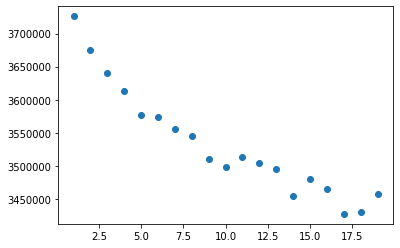

In [19]:
from sklearn.cluster import MiniBatchKMeans #군집분석
#elbow point로 k = 7을 선정
wss=[]
for i in range(1,20):
    kmeans=MiniBatchKMeans(n_clusters=i)
    kmeans.fit(data_trans)
    wss.append(kmeans.inertia_)
    print(i)
	
np.shape(data_trans)
plt.scatter(range(1,20), wss)
plt.show()

In [20]:
K=7
kmeans=MiniBatchKMeans(n_clusters=K)
kmeans.fit(data_trans)
clusters3 = kmeans.labels_
(clusters3)

clusters=clusters3
K=7
unique, counts = np.unique(clusters, return_counts=True)
clusters , K , unique , counts

(array([1, 6, 2, ..., 2, 5, 0]),
 7,
 array([0, 1, 2, 3, 4, 5, 6]),
 array([ 9418, 10417, 10319,  9683, 10561,  9511, 10091], dtype=int64))

In [21]:
n=data.shape[0] #군집의 엔트로피 구하기
H_C=0

for k in range(K): # k-th cluster
    n_k=counts[k]
    idx=np.where(clusters==k)
    n_category=0

    for j in range(data.shape[1]): # j-th attribute , j : 상품 번호               
        x=data.iloc[idx[0], j]
        unique_x, counts_x = np.unique(x, return_counts=True)
        
        for m in range(len(counts_x)): # m-th category, m : 상품별 카테고리
            N_jk1=counts_x[m]
            H_C+=-(N_jk1/n_k * np.log(N_jk1/n_k)) * n_k / n
            n_category += 1        

N_jk1 , n_category
H_C #총 엔트로피의 합 219.06470692700546

219.06470692700546

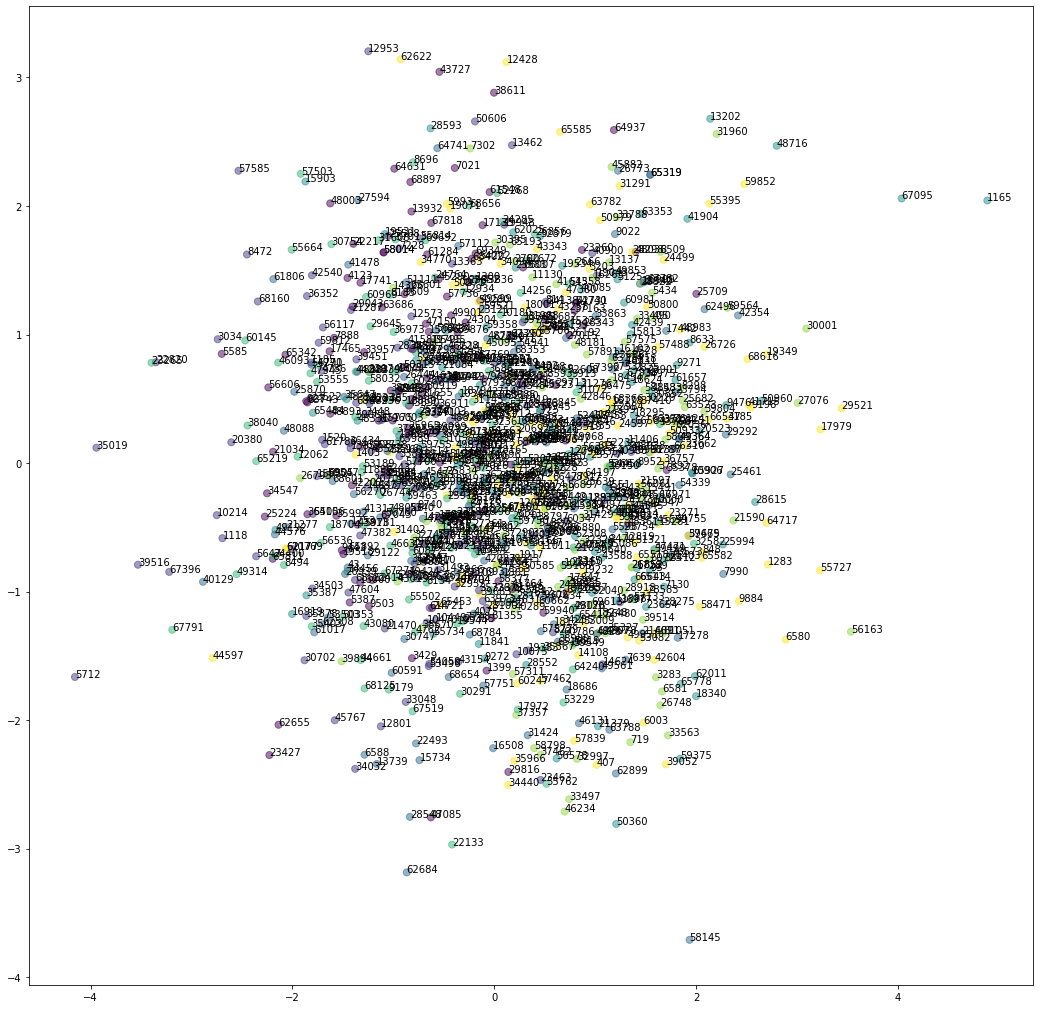

In [22]:
plt.figure(figsize=(18, 18)) 
area = 50
plt.scatter(result2[:, 0], result2[:, 1] , c=clusters[cho_idx]+1, s = area , alpha=0.5)
words = list(data.index[cho_idx])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result2[i, 0], result2[i, 1]))
plt.show()

In [23]:
clusters[cho_idx] ,  result2.shape

cus_names = list(data.index[cho_idx])
len(cus_names)

result3 = np.dot(result2 , result2.T)
result3

import pandas as pd 

df = pd.DataFrame(result3)
df.index = cus_names
df.columns = cus_names
df.to_csv("유사도_UBCF.csv")

In [24]:
df

42540     46131     7962      17741     25639     58809     7892   \
42540  5.395690 -4.472649  1.140740  4.442986 -1.842280 -0.275971  0.810525   
46131 -4.472649  4.803054 -1.409583 -3.952177  1.079984  0.418580 -0.574966   
7962   1.140740 -1.409583  0.437683  1.053358 -0.200115 -0.138738  0.130318   
17741  4.442986 -3.952177  1.053358  3.724674 -1.407100 -0.273896  0.643597   
25639 -1.842280  1.079984 -0.200115 -1.407100  0.811515  0.016753 -0.316292   
...         ...       ...       ...       ...       ...       ...       ...   
718    0.821031 -1.845483  0.666947  0.962364  0.195119 -0.243830  0.020295   
35162 -0.782580  0.677225 -0.177530 -0.651411  0.255560  0.044968 -0.115034   
55395 -0.900693 -2.299972  1.099885  0.007102  1.550968 -0.481798 -0.404774   
55502 -0.027830  1.442755 -0.607157 -0.371834 -0.569932  0.247405  0.121393   
34440 -3.911917  5.189107 -1.651396 -3.699569  0.541258  0.537324 -0.415475   

          15353     35024     54202  ...     30291     29645     25150  \
42540  0.877870 -2.563441  2.590019  ... -2.012502  3.767703 -2.525932   
46131 -1.095247  0.761117 -3.346367  ...  3.352475 -3.182114  2.232316   
7962   0.341265  0.035648  1.055560  ... -1.138801  0.821524 -0.592681   
17741  0.813201 -1.775639  2.427490  ... -2.071100  3.116938 -2.113973   
25639 -0.149721  1.431872 -0.394789  ... -0.000275 -1.262366  0.805917   
...         ...       ...       ...  ...       ...       ...       ...   
718    0.524406  1.060081  1.669472  ... -2.097122  0.635995 -0.531620   
35162 -0.136893  0.336291 -0.406877  ...  0.335737 -0.547995  0.369962   
55395  0.875588  4.220480  2.903117  ... -4.347781 -0.464994  0.036510   
55502 -0.480833 -1.754089 -1.567662  ...  2.192963 -0.095829  0.192501   
34440 -1.289480 -0.564482 -4.008746  ...  4.451418 -2.836353  2.077379   

          42150     51111     718       35162     55395     55502     34440  
42540  1.204678  3.624074  0.821031 -0.782580 -0.900693 -0.027830 -3.911917  
46131 -0.589674 -3.577252 -1.845483  0.677225 -2.299972  1.442755  5.189107  
7962   0.081501  1.008934  0.666947 -0.177530  1.099885 -0.607157 -1.651396  
17741  0.891470  3.125043  0.962364 -0.651411  0.007102 -0.371834 -3.699569  
25639 -0.578217 -1.003461  0.195119  0.255560  1.550968 -0.569932  0.541258  
...         ...       ...       ...       ...       ...       ...       ...  
718   -0.251502  1.160892  1.363594 -0.149408  3.102426 -1.513809 -2.664892  
35162 -0.164078 -0.540550 -0.149408  0.114246  0.051320  0.040997  0.618049  
55395 -1.338256  0.988904  3.102426  0.051320  8.622574 -3.943350 -4.759724  
55502  0.523696 -0.761422 -1.513809  0.040997 -3.943350  1.839882  2.542472  
34440 -0.146891 -3.645770 -2.664892  0.618049 -4.759724  2.542472  6.294258  

[1000 rows x 1000 columns]